#Adat előkészítés

In [ ]:
!pip install gdown

In [ ]:
import json
import gdown

# URL or ID of the file
file_url = "https://drive.google.com/uc?id=1sw13T_LsywHmuH_eC9ePP1fpUGJgqF_6"
output = "poems.json"  # Name to save the file
gdown.download(file_url, output, quiet=False)
# https://drive.google.com/uc?id=1sw13T_LsywHmuH_eC9ePP1fpUGJgqF_6
# 1sw13T_LsywHmuH_eC9ePP1fpUGJgqF_6

with open(output, 'r') as file:
    poems = json.load(file)

Downloading...
From: https://drive.google.com/uc?id=1sw13T_LsywHmuH_eC9ePP1fpUGJgqF_6
To: /content/poems.json
100%|██████████| 1.18M/1.18M [00:00<00:00, 146MB/s]


#Kutatás, érdekességek

#ITK HPC Cluster, egybe verzió

In [ ]:
import os
import csv
import torch
import torch.nn as nn
from torch.nn import functional as F
from transformers import PreTrainedTokenizerFast
import random
import json

batch_size = 16  # simultanious processed poems
block_size = 512 # max poem size

learning_rate = 5 * 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 10
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.1

# Reading the file
output = "Petofi_corpus.json"
with open(output, 'r') as file:
    poems = json.load(file)

# Initialize a new tokenizer
tokenizer = PreTrainedTokenizerFast.from_pretrained("gpt2")
special_tokens = ["<TITLE>", "<BODY>", "<ORIGIN>", "<END>", "<PAD>", "<UNK>"]
tokenizer.add_special_tokens({"additional_special_tokens": special_tokens})

unknown_id = tokenizer.encode("<UNK>")[0]
padding_id = tokenizer.encode("<PAD>")[0]
ending_id = tokenizer.encode("<END>")[0]

# Encoding the file and calculating a simple vocabulary
encoded_poems = []
simplified_vocab = set()
for poem in poems:
    encoded_body = []
    for verse in poem['body']:
      encoded_verse = tokenizer.encode(verse + "\n\n")
      simplified_vocab.update(encoded_verse)
      encoded_body.append(encoded_verse)

    encoded_poem = {
        "title": tokenizer.encode(f"<TITLE>{poem['title']}\n\n<BODY>"),
        "origin": tokenizer.encode(f"<ORIGIN>{poem['origin']}<END>"),
        "body": encoded_body
    }
    simplified_vocab.update(encoded_poem["title"])
    simplified_vocab.update(encoded_poem["origin"])

    encoded_poems.append(encoded_poem)

# adding special_tokens to vocab
for token in special_tokens:
    simplified_vocab.update(tokenizer.encode(token))

# IMPORTANT: reducing vocab size, from original ~50k to 3.4k
vocab_size = len(simplified_vocab)

simplified_vocab_listed = sorted(list(simplified_vocab))
simple_unknown_id = simplified_vocab_listed.index(unknown_id)
simple_padding_id = simplified_vocab_listed.index(padding_id)
simple_ending_id = simplified_vocab_listed.index(ending_id)

# Simplified to original is easy, use the vocab as a dictionary.
simplified_to_original_map = torch.tensor(simplified_vocab_listed, dtype=torch.long)

# Original to simplified, reverse the dictionary just created and fill holes with unknown id (OF SIMPLIFIED!)
max_token_id = tokenizer.vocab_size + len(special_tokens)
original_to_simplified_map = torch.full((max_token_id,), simple_unknown_id, dtype=torch.long)

# index: simplified ID <- token: original ID
for index, value in enumerate(simplified_vocab_listed):
    original_to_simplified_map[value] = index

def original_to_simplified(input_tokens) -> torch.Tensor:
    # if everything goes well, clamping here is not needed
    input_tokens = torch.tensor(input_tokens, dtype=torch.long)
    input_tokens = torch.clamp(input_tokens, 0, max_token_id - 1)
    simplified_tokens = original_to_simplified_map[input_tokens]
    return simplified_tokens

def simplified_to_original(input_tokens: torch.Tensor):
    original_tokens = simplified_to_original_map[input_tokens]
    return original_tokens.tolist()

# encoding the poems with using the simple vocab
for poem in encoded_poems:
  poem["title"] = original_to_simplified(poem["title"])
  poem["origin"] = original_to_simplified(poem["origin"])
  for i in range(len(poem["body"])):
    poem["body"][i] = original_to_simplified(poem["body"][i])

random.shuffle(encoded_poems)
split_idx = int(0.9 * len(encoded_poems))
train_poems = encoded_poems[:split_idx]
val_poems = encoded_poems[split_idx:]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [ ]:
def get_batch(split):
    data = train_poems if split == 'train' else val_poems
    x_batch, y_batch = [], []

    for idx in range(batch_size):
        poem_data = random.choice(data)

        body_data = torch.empty(0, dtype=torch.long)
        body_size = block_size - len(poem_data["title"]) - len(poem_data["origin"])

        # # choose a random position to start, than suround with verses
        verse_num = len(poem_data["body"])
        start_index = random.randint(0, verse_num-1)

        # More likely to start at the beginning!
        for i in range(verse_num):
          if (start_index - i >= 0):
            extended_body = torch.cat((poem_data["body"][start_index - i], body_data))
            if (len(extended_body) > body_size):
              break
          else:
            extended_body = torch.cat((body_data, poem_data["body"][i]))
            if (len(extended_body) > body_size):
              break
          body_data = extended_body

        # putting encoded data together
        encoded_body_data = torch.cat((poem_data["title"], body_data, poem_data["origin"]))

        # extend it further to make sure it is the right length.
        final_data = torch.cat((encoded_body_data, torch.tensor([simple_padding_id] * (block_size + 1 - len(encoded_body_data)), dtype=torch.long)))

        x_batch.append(final_data[0:-1])
        y_batch.append(final_data[1:])

    # Stack and move to device
    x = torch.stack(x_batch).to(device)
    y = torch.stack(y_batch).to(device)

    return x, y

In [ ]:
import os
import csv
import torch
import torch.nn as nn
from torch.nn import functional as F
from transformers import PreTrainedTokenizerFast
import random
import json

batch_size = 16
block_size = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 256
n_head = 4
n_layer = 4
dropout = 0.15

output = "Petofi_corpus_split.json"
with open(output, 'r') as file:
    poems = json.load(file)

# Initialize a new tokenizer
tokenizer = PreTrainedTokenizerFast.from_pretrained("gpt2")
special_tokens = ["<TITLE>", "<BODY>", "<ORIGIN>", "<END>", "<PAD>", "<UNK>"]
tokenizer.add_special_tokens({"additional_special_tokens": special_tokens})

unknown_id = tokenizer.encode("<UNK>")[0]
padding_id = tokenizer.encode("<PAD>")[0]
ending_id = tokenizer.encode("<END>")[0]

# Encoding the file and calculating a simple vocabulary
encoded_poems = []
simplified_vocab = set()
for poem in poems:
    encoded_body = []
    for verse in poem['body']:
      encoded_verse = tokenizer.encode(verse + "\n\n")
      simplified_vocab.update(encoded_verse)
      encoded_body.append(encoded_verse)

    encoded_poem = {
        "title": tokenizer.encode(f"<TITLE>{poem['title']}\n\n<BODY>"),
        "origin": tokenizer.encode(f"<ORIGIN>{poem['origin']}<END>"),
        "body": encoded_body
    }
    simplified_vocab.update(encoded_poem["title"])
    simplified_vocab.update(encoded_poem["origin"])

    encoded_poems.append(encoded_poem)

for token in special_tokens:
    simplified_vocab.update(tokenizer.encode(token))

# IMPORTANT: reducing vocab size, from original ~50k to 3.4k
vocab_size = len(simplified_vocab)

simplified_vocab_listed = sorted(list(simplified_vocab))
simple_unknown_id = simplified_vocab_listed.index(unknown_id)
simple_padding_id = simplified_vocab_listed.index(padding_id)
simple_ending_id = simplified_vocab_listed.index(ending_id)

# Simplified to original is easy, use the vocab as a dictionary.
simplified_to_original_map = torch.tensor(simplified_vocab_listed, dtype=torch.long)

# Original to simplified, reverse the dictionary just created and fill holes with unknown id (OF SIMPLIFIED!)
max_token_id = tokenizer.vocab_size + len(special_tokens)
original_to_simplified_map = torch.full((max_token_id,), simple_unknown_id, dtype=torch.long)

# index: simplified ID <- token: original ID
for index, value in enumerate(simplified_vocab_listed):
    original_to_simplified_map[value] = index

def original_to_simplified(input_tokens) -> torch.Tensor:
    # if everything goes well, clamping here is not needed
    input_tokens = torch.tensor(input_tokens, dtype=torch.long)
    input_tokens = torch.clamp(input_tokens, 0, max_token_id - 1)
    simplified_tokens = original_to_simplified_map[input_tokens]
    return simplified_tokens

def simplified_to_original(input_tokens: torch.Tensor):
    original_tokens = simplified_to_original_map[input_tokens]
    return original_tokens.tolist()

# encoding the poems with using the simple vocab
for poem in encoded_poems:
  poem["title"] = original_to_simplified(poem["title"])
  poem["origin"] = original_to_simplified(poem["origin"])
  for i in range(len(poem["body"])):
    poem["body"][i] = original_to_simplified(poem["body"][i])

random.shuffle(encoded_poems)

def get_batch(split):
    if split == 'train':
      data = train_poems
    else:
      data = val_poems
    x_batch, y_batch = [], []


    for idx in range(batch_size):
        poem_data = random.choice(data)
        # print(tokenizer.decode(simplified_to_original(poem_data["title"])))
        body_data = torch.empty(0, dtype=torch.long)
        body_size = block_size - len(poem_data["title"]) - len(poem_data["origin"])

        # # choose a random position to start, than suround with verses
        verse_num = len(poem_data["body"])
        start_index = random.randint(0, verse_num-1)

        # More likely to start at the beginning!
        for i in range(verse_num):
          if (start_index - i >= 0):
            extended_body = torch.cat((poem_data["body"][start_index - i], body_data))
            if (len(extended_body) > body_size):
              break
          else:
            extended_body = torch.cat((body_data, poem_data["body"][i]))
            if (len(extended_body) > body_size):
              break
          body_data = extended_body

        # putting encoded data together
        encoded_body_data = torch.cat((poem_data["title"], body_data, poem_data["origin"]))

        # extend it further to make sure it is the right length.
        final_data = torch.cat((encoded_body_data, torch.tensor([simple_padding_id] * (block_size + 1 - len(encoded_body_data)), dtype=torch.long)))

        x_batch.append(final_data[0:-1])
        y_batch.append(final_data[1:])

    # Stack and move to device
    x = torch.stack(x_batch).to(device)
    y = torch.stack(y_batch).to(device)

    return x, y

def get_batch_from_data(data_subset):
    x_batch, y_batch = [], []

    for _ in range(batch_size):
        poem_data = random.choice(data_subset)
        body_data = torch.empty(0, dtype=torch.long)
        body_size = block_size - len(poem_data["title"]) - len(poem_data["origin"])

        # Construct the body
        verse_num = len(poem_data["body"])
        start_index = random.randint(0, verse_num - 1)

        for i in range(verse_num):
            if start_index - i >= 0:
                extended_body = torch.cat((poem_data["body"][start_index - i], body_data))
                if len(extended_body) > body_size:
                    break
            else:
                extended_body = torch.cat((body_data, poem_data["body"][i]))
                if len(extended_body) > body_size:
                    break
            body_data = extended_body

        # Final data construction
        encoded_body_data = torch.cat((poem_data["title"], body_data, poem_data["origin"]))
        final_data = torch.cat((encoded_body_data, torch.tensor([simple_padding_id] * (block_size + 1 - len(encoded_body_data)), dtype=torch.long)))

        x_batch.append(final_data[0:-1])
        y_batch.append(final_data[1:])

    x = torch.stack(x_batch).to(device)
    y = torch.stack(y_batch).to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

@torch.no_grad()
def estimate_loss_on_subset(data_subset, batch_size):
    losses = []
    for i in range(0, len(data_subset), batch_size):
        # Prepare batch
        batch_data = data_subset[i:i + batch_size]
        x_batch, y_batch = get_batch_from_data(batch_data)

        # Forward pass
        logits, loss = model(x_batch, y_batch)
        losses.append(loss.item())

    return np.mean(losses)

class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class DecoderOnlyTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets, ignore_index = simple_padding_id)

        return logits, loss

    def generate(self, idx, max_new_tokens):
      generated_tokens = []

      for _ in range(max_new_tokens):
          # Use the last `block_size` tokens as input context
          idx_cond = idx[:, -block_size:]
          logits, _ = self(idx_cond)

          # Focus on the logits of the last token and convert to probabilities
          logits = logits[:, -1, :]
          probs = F.softmax(logits, dim=-1)

          # Sample the next token
          idx_next = torch.multinomial(probs, num_samples=1)
          idx = torch.cat((idx, idx_next), dim=1)

          # If EOS token is generated, stop early
          if idx_next.item() == simple_ending_id:
              break
          generated_tokens.append(idx_next.item())

      return generated_tokens

model = DecoderOnlyTransformer().to(device)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [ ]:
fold_train_losses = []
fold_val_losses = []

train_losses = []
val_losses = []

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

max_iters = 1000
eval_interval = 100

# Prepare 5-fold split
kf = KFold(n_splits=5, shuffle=True, random_state=42)
folds = list(kf.split(encoded_poems))

# Cross-validation training loop

for fold_idx, (train_indices, val_indices) in enumerate(folds):
    print(f"\nStarting Fold {fold_idx + 1}...")

    # Split data into training and validation for this fold
    train_poems = [encoded_poems[i] for i in train_indices]
    val_poems = [encoded_poems[i] for i in val_indices]

    # Initialize optimizer and scheduler for this fold
    optimizer = torch.optim.AdamW(model.parameters(), lr=5*1e-5, weight_decay=0.00025)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)

    current_train_losses = []
    current_val_losses = []

    # Training loop for the current fold
    for iter in range(max_iters):
        # Evaluate loss at intervals
        if iter % eval_interval == 0 or iter == max_iters - 1:
            model.eval()
            train_loss = estimate_loss_on_subset(train_poems, batch_size)
            val_loss = estimate_loss_on_subset(val_poems, batch_size)
            current_train_losses.append(train_loss)
            current_val_losses.append(val_loss)
            model.train()
            print(f"Fold {fold_idx + 1}, Step {iter}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}")

        # Training step
        xb, yb = get_batch_from_data(train_poems)  # Generate training batch
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        scheduler.step()

    # Save losses for this fold
    train_losses.extend(current_train_losses)
    val_losses.extend(current_val_losses)

    fold_train_losses.append(np.mean(current_train_losses))
    fold_val_losses.append(np.mean(current_val_losses))

# Print final cross-validation results
avg_train_loss = np.mean(fold_train_losses)
avg_val_loss = np.mean(fold_val_losses)
print(f"\nCross-Validation Results: Average Train Loss = {avg_train_loss:.4f}, Average Val Loss = {avg_val_loss:.4f}")


Starting Fold 1...
Fold 1, Step 0: Train Loss 0.0763, Val Loss 0.0697
Fold 1, Step 100: Train Loss 0.0756, Val Loss 0.0697
Fold 1, Step 200: Train Loss 0.0756, Val Loss 0.0712
Fold 1, Step 300: Train Loss 0.0745, Val Loss 0.0744
Fold 1, Step 400: Train Loss 0.0736, Val Loss 0.0722
Fold 1, Step 500: Train Loss 0.0729, Val Loss 0.0718
Fold 1, Step 600: Train Loss 0.0730, Val Loss 0.0742
Fold 1, Step 700: Train Loss 0.0710, Val Loss 0.0751
Fold 1, Step 800: Train Loss 0.0706, Val Loss 0.0770
Fold 1, Step 900: Train Loss 0.0727, Val Loss 0.0738
Fold 1, Step 999: Train Loss 0.0722, Val Loss 0.0757

Starting Fold 2...
Fold 2, Step 0: Train Loss 0.0733, Val Loss 0.0702
Fold 2, Step 100: Train Loss 0.0721, Val Loss 0.0717
Fold 2, Step 200: Train Loss 0.0712, Val Loss 0.0726
Fold 2, Step 300: Train Loss 0.0732, Val Loss 0.0754
Fold 2, Step 400: Train Loss 0.0726, Val Loss 0.0744
Fold 2, Step 500: Train Loss 0.0721, Val Loss 0.0739
Fold 2, Step 600: Train Loss 0.0704, Val Loss 0.0765
Fold 2, St

In [ ]:
def save_logs(train_losses, val_losses, filename="loss_logs.csv"):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Step", "Train Loss", "Validation Loss"])
        for i, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses)):
            writer.writerow([i * eval_interval, train_loss, val_loss])
    print(f"Logs saved to {filename}")

def save_weights(model, file_path="weights01.csv"):
    with open(file_path, 'w', newline='') as f:
        writer = csv.writer(f)
        for name, param in model.state_dict().items():
            writer.writerow([name, param.shape, param.flatten().tolist()])
    print(f"Weights saved to {file_path}.")

Logs saved to actual.csv


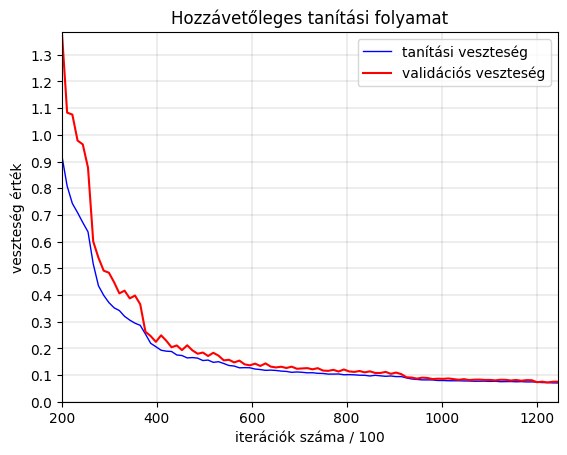

In [ ]:
import matplotlib.pyplot as plt

# viszonylag úl nagy, 0.075-ös weight decay-el

# Plot the points and connect them
# plt.plot(x, y, marker='o', linestyle='-', color='b')  # 'o' for dots, '-' for lines
# plt.plot(val_losses, color='r', linewidth=1)
# plt.plot(train_losses, color='b', linewidth=1)

train_dots = [train_losses[0]] + fold_train_losses
val_dots = [max(val_losses)] + fold_val_losses
plt.plot(np.linspace(0,len(train_losses),len(train_dots)), train_dots, linestyle='-', color='b', linewidth=1)
plt.plot(np.linspace(0,len(train_losses),len(val_dots)), val_dots, linestyle='-', color='r')

# Add labels and title for clarity (optional)
plt.title("Hozzávetőleges tanítási folyamat")
plt.xlabel("iterációk száma / 100")
plt.ylabel("veszteség érték")
plt.grid(color='k', linestyle='-', linewidth=0.1)

y_tick_positions = np.arange(0, max(val_losses) + 0.1, 0.1)

plt.yticks(y_tick_positions)

x_tick_positions = np.arange(0, len(train_losses), step=200)  # Tick positions (starting from 0)
x_tick_labels = x_tick_positions + 200  # Shift the labels by 200
plt.xticks(x_tick_positions, labels=x_tick_labels)

plt.xlim((0,len(train_losses)))
plt.ylim((0,max(val_losses)))

save_logs(train_dots, val_dots, "actual.csv")

plt.legend(["tanítási veszteség", "validációs veszteség"], loc="upper right")

# save_weights(model)

# Show the plot
plt.show()

95
Logs saved to actual.csv


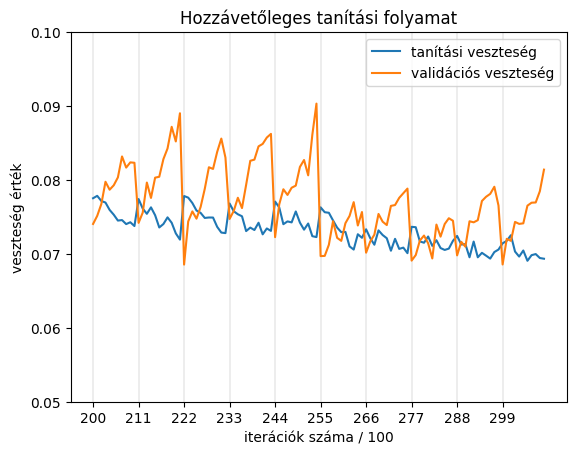

In [ ]:
import matplotlib.pyplot as plt

# viszonylag úl nagy, 0.075-ös weight decay-el

# Plot the points and connect them
# plt.plot(x, y, marker='o', linestyle='-', color='b')  # 'o' for dots, '-' for lines
# plt.plot(val_losses, color='r', linewidth=1)
# plt.plot(train_losses, color='b', linewidth=1)

train_dots = train_losses[-110:]
val_dots = val_losses[-110:]
print(len(fold_train_losses))
# plt.plot(np.linspace(0,len(train_dots),len(train_dots)), train_dots, linestyle='-', color='b', linewidth=1)
# plt.plot(np.linspace(0,len(val_dots),len(val_dots)), val_dots, linestyle='-', color='r')

plt.plot(train_dots)
plt.plot(val_dots)

# Add labels and title for clarity (optional)
plt.title("Hozzávetőleges tanítási folyamat")
plt.xlabel("iterációk száma / 100")
plt.ylabel("veszteség érték")
plt.grid(color='k', axis='x', linestyle='-', linewidth=0.1)

x_tick_positions = np.arange(0, len(train_dots), step=11)  # Tick positions (starting from 0)
x_tick_labels = x_tick_positions + 200  # Shift the labels by 200
plt.xticks(x_tick_positions, labels=x_tick_labels)

plt.xlim((0,len(train_losses)))
plt.ylim((0.05,0.1))

save_logs(train_dots, val_dots, "actual.csv")

plt.legend(["tanítási veszteség", "validációs veszteség"], loc="upper right")

# save_weights(model)

# Show the plot
plt.show()

In [ ]:
save_weights(model)

Weights saved to weights01.csv.


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5*1e-3, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)

train_losses = []
val_losses = []

# Training loop
for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses.append(losses['train'].item())
        val_losses.append(losses['val'].item())
        print(f"step {iter}: train loss {train_losses[-1]:.4f}, val loss {val_losses[-1]:.4f}")

    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    scheduler.step()

def save_logs(train_losses, val_losses, filename="loss_logs.csv"):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Step", "Train Loss", "Validation Loss"])
        for i, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses)):
            writer.writerow([i * eval_interval, train_loss, val_loss])
    print(f"Logs saved to {filename}")

def save_weights(model, file_path="weights01.csv"):
    with open(file_path, 'w', newline='') as f:
        writer = csv.writer(f)
        for name, param in model.state_dict().items():
            writer.writerow([name, param.shape, param.flatten().tolist()])
    print(f"Weights saved to {file_path}.")

save_logs(train_losses, val_losses)
save_weights(model)

SyntaxError: invalid decimal literal (<ipython-input-166-1d66dcb3915c>, line 1)

In [ ]:
def load_weights(model, file_path):
    """
    Load model weights from a CSV file.
    Args:
        model (torch.nn.Module): The model to load weights into.
        file_path (str): Path to the CSV file where weights are stored.
    """
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        state_dict = {}
        for row in reader:
            name = row[0]
            shape = eval(row[1])  # Convert shape back to tuple
            weights = torch.tensor(eval(row[2])).view(shape)  # Convert to tensor and reshape
            state_dict[name] = weights
        model.load_state_dict(state_dict)
    print(f"Weights loaded from {file_path}.")

In [ ]:
prompt = "<TITLE>"
input_ids = original_to_simplified(torch.tensor([tokenizer.encode(prompt)], dtype=torch.long)).to(device)

generated_poem = model.generate(input_ids, max_new_tokens=1000)

print(tokenizer.decode(simplified_to_original(generated_poem)))

<ipython-input-157-0d36d5a6af26>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tokens = torch.tensor(input_tokens, dtype=torch.long)


Színbirálat

<BODY>  S tovább hát... most szavai?
  Vagy tán kérdén is szekérdezék.
  Mert a pisza reá nem gyulva,
  S még nincsen itt volna?
  Hogy e szerzik falát szomszék a széh meg?
  És többé vagy oly szükszelhez -
  Rövid: a kor istenno
  Német, ha csak nem volt, jók valának,
  Azt is teremtésére.

<ORIGIN>Pest


In [ ]:
print("Total paramteres:", sum(p.numel() for p in model.parameters()))
print("Vocab_size:", len(simplified_vocab))
print("Embedding / Unembedding matricies size:", len(simplified_vocab) * n_embd)
matrix_size = n_embd* n_embd
print("K, Q, V matricies sizes:", n_embd* n_embd)
head_size = n_embd // n_head * n_embd * 3
print("single head size:", head_size)
attention_size = head_size * n_head
print("Multiheaded attention size:", attention_size)
perceptron_size = n_embd * n_embd * 4 * 2
print("Multilayer perceptron size:", perceptron_size)

print("Total paramteres:", sum(p.numel() for p in model.parameters()))

# block_size = n_head * n_embd * 3 + n_embd * n_embd * 4 * 2
# model_size = block_size * n_layer + len(simplified_vocab) * n_embd * 2

block_size = n_head * n_embd * 3 + n_embd * n_embd * 4 * 2  # original block_size
ln_params_per_block = n_embd * 2  # LayerNorm params: gain and bias
linear_biases_per_block = n_embd * (1 + 3 + 1 + 2)
model_size = (block_size + ln_params_per_block + linear_biases_per_block) * n_layer + len(simplified_vocab) * n_embd * 2 + len(simplified_vocab)
print(model_size)
print(sum(p.numel() for p in model.parameters()))

Total paramteres: 16373085
Vocab_size: 3421
Embedding / Unembedding matricies size: 1751552
K, Q, V matricies sizes: 262144
single head size: 196608
Multiheaded attention size: 786432
Multilayer perceptron size: 2097152
Total paramteres: 16373085
11938141
16373085


In [ ]:
# Original block_size
block_size = n_head * n_embd * 3 + n_embd * n_embd * 4 * 2

# Layer Normalization params
ln_params_per_block = n_embd * 2

# Attention mechanism params: key, query, value, projection
attn_params_per_block = n_head * ((n_embd**2 * 3) // n_head + n_embd**2)
attn_biases_per_block = n_embd * 4

# Feedforward params
ffwd_params_per_block = n_embd**2 * 4 * 2 + 4 * n_embd + n_embd

# Total params per block
block_params = ln_params_per_block + attn_params_per_block + attn_biases_per_block + ffwd_params_per_block

# Embedding table params
embedding_params = len(simplified_vocab) * n_embd

# Positional embedding params
positional_embedding_params = 512 * n_embd

# Language modeling head params
lm_head_params = n_embd * len(simplified_vocab) + len(simplified_vocab)

# Total model size
model_size = block_params * n_layer + embedding_params + positional_embedding_params + lm_head_params

print(model_size)
print(sum(p.numel() for p in model.parameters()))

19519837
16373085


In [ ]:
def print_model_parameters(model):
    print(f"{'Layer':<40} {'Shape':<30} {'Param Count'}")
    print("=" * 80)
    total_params = 0
    for name, param in model.named_parameters():
        param_count = param.numel()
        print(f"{name:<40} {str(list(param.shape)):<30} {param_count}")
        total_params += param_count
    print("=" * 80)
    print(f"Total Parameters: {total_params}")

# Call the function for your model
print_model_parameters(model)

Layer                                    Shape                          Param Count
token_embedding_table.weight             [3421, 512]                    1751552
position_embedding_table.weight          [512, 512]                     262144
blocks.0.sa.heads.0.key.weight           [128, 512]                     65536
blocks.0.sa.heads.0.query.weight         [128, 512]                     65536
blocks.0.sa.heads.0.value.weight         [128, 512]                     65536
blocks.0.sa.heads.1.key.weight           [128, 512]                     65536
blocks.0.sa.heads.1.query.weight         [128, 512]                     65536
blocks.0.sa.heads.1.value.weight         [128, 512]                     65536
blocks.0.sa.heads.2.key.weight           [128, 512]                     65536
blocks.0.sa.heads.2.query.weight         [128, 512]                     65536
blocks.0.sa.heads.2.value.weight         [128, 512]                     65536
blocks.0.sa.heads.3.key.weight           [128, 512]    

In [ ]:
# the three matricies per head, + the output matrix (+1 for bias)
KQV_matrix_params = (n_embd // n_head) * n_embd
output_matrix_params = n_embd**2 + n_embd

# the upprojection and the downprojection layers have the same amount of params.
# Also the down projection layer has 4 times the biases, so 5 * n_embd in total
multilayer_perceptron_params = (n_embd**2 * 4) * 2 + 5 * n_embd

embedding_params = n_embd * len(simplified_vocab)
#TODO: explain
linear_norm_params = n_embd * 2

pos_embedding_params = n_embd**2

multiheaded_attention_params = KQV_matrix_params * 3 * n_head + output_matrix_params
block_params = multiheaded_attention_params + multilayer_perceptron_params + linear_norm_params * 2

total_params = embedding_params * 2 + pos_embedding_params + block_params * n_layer + linear_norm_params + len(simplified_vocab)

print(total_params)

16373085
16373085


In [ ]:
prompt = "<TITLE>Jó költonek tartanak..."
input_ids = original_to_simplified(torch.tensor([tokenizer.encode(prompt)], dtype=torch.long)).to(device)

generated_poem = model.generate(input_ids, max_new_tokens=1000)

print(tokenizer.decode(simplified_to_original(generated_poem)))

<ipython-input-10-9cdc1651555f>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tokens = torch.tensor(input_tokens, dtype=torch.long)




<BODY>  Jó költonek tartanak, s hogy
  Az vagyok, én is hiszem,
  De azért te ne magasztald
  Verseimet, kedvesem.

  Te elotted elpirúl,
  Azt hiszen üdvezelve, jobban vagy,
  Azt tudtalan volt szeretszóltágakadókat én,
  Hogy minket,
  Vagy áldásra?
  Szivem volt az,
  Azutának hogy mi ok mondoltál?
  Sokfedot is gondolat
  És mind elfeledted lelkelt;
  De még, nem sz a rózsz esi el a korbályat szemk eskül a
  Hogy mondd,
  Mert nekem,
  Verseyelemk, mert a mi végbb vagy istene,
  Te ide velembe',
  Ha kell hogy is,
  Mely, kedves gondolatodából a böl nem újra
  Aztán kisebb szép,

  Hogyha tán visszagok,
  Az volt, ki rá,

  Az ég fekete,
  Akasztatódat e virág.

  Remény,
  Hogy fiútjéigyszerre lehetett.

  Ha majd felhagytam a halottem,
  Melyet be,
  Mint elfolyg van ebben -

<ORIGIN>Szatmár
